# Задание  
Напишите на Python реализацию как минимум одного алгоритма на выбор: любая на выбор цветовая обработка, перевод в другое цветовое пространство или фильтрация. Изображение выберите самостоятельно.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import imageio

## Загрузка цветного изображения

In [2]:
img = imageio.imread('syrikaty-47-768x570.jpg')
img = img.astype(np.float32) / 255.
print(img.shape)

(570, 768, 3)


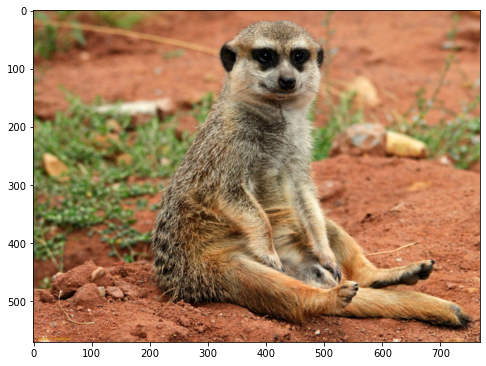

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow(img)

## Получение ЧБ изображения по цветному

In [4]:
img_bw = np.mean(img, axis=2)
print(img_bw.shape)

(570, 768)


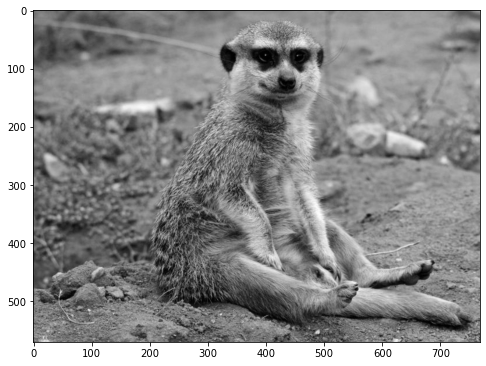

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(img_bw, cmap='gray')

## Цветовое пространство HSV

In [6]:
from skimage.color import rgb2hsv, hsv2rgb

In [7]:
img_hsv = rgb2hsv(img)

## Линейное увеличение насыщенности (Saturation)
Возможен выход за пределы допустимого диапазона

In [8]:
img_hsv_new = np.copy(img_hsv)
img_hsv_new[:, :, 1] *= 2
img_new = hsv2rgb(img_hsv_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


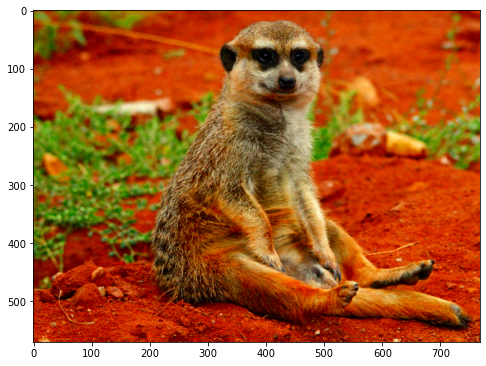

In [9]:
plt.figure(figsize=(8, 8))
plt.imshow(img_new)

## Линейное увеличение яркости (Value)
Возможен выход за пределы допустимого диапазона

In [10]:
img_hsv_new = np.copy(img_hsv)
img_hsv_new[:, :, 2] *= 2
img_new = hsv2rgb(img_hsv_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


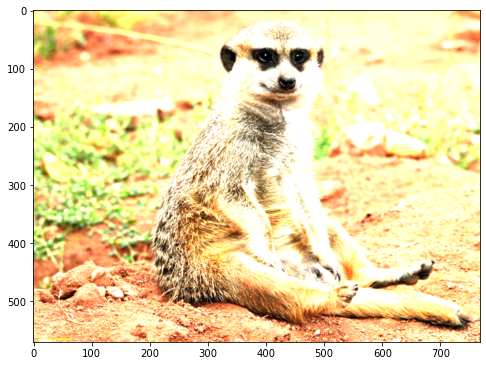

In [11]:
plt.figure(figsize=(8, 8))
plt.imshow(img_new)

## Gaussian blur

In [12]:
import scipy.signal

In [13]:
win_size = (11, 11)
sigma = 3
w = np.zeros(win_size, dtype=np.float32)
for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        w[i,j] = np.exp(-(i-w.shape[0]//2)**2 / sigma**2 / 2 
                        -(j-w.shape[1]//2)**2 / sigma**2 / 2)
w = w / np.sum(w)

[[0.00125904 0.0020758  0.00306252 0.00404311 0.00477637 0.00504924
  0.00477637 0.00404311 0.00306252 0.0020758  0.00125904]
 [0.0020758  0.00342242 0.00504924 0.00666597 0.00787491 0.00832479
  0.00787491 0.00666597 0.00504924 0.00342242 0.0020758 ]
 [0.00306252 0.00504924 0.00744935 0.00983457 0.01161817 0.01228189
  0.01161817 0.00983457 0.00744935 0.00504924 0.00306252]
 [0.00404311 0.00666597 0.00983457 0.01298353 0.01533823 0.01621447
  0.01533823 0.01298353 0.00983457 0.00666597 0.00404311]
 [0.00477637 0.00787491 0.01161817 0.01533823 0.01811998 0.01915513
  0.01811998 0.01533823 0.01161817 0.00787491 0.00477637]
 [0.00504924 0.00832479 0.01228189 0.01621447 0.01915513 0.02024942
  0.01915513 0.01621447 0.01228189 0.00832479 0.00504924]
 [0.00477637 0.00787491 0.01161817 0.01533823 0.01811998 0.01915513
  0.01811998 0.01533823 0.01161817 0.00787491 0.00477637]
 [0.00404311 0.00666597 0.00983457 0.01298353 0.01533823 0.01621447
  0.01533823 0.01298353 0.00983457 0.00666597 0.00

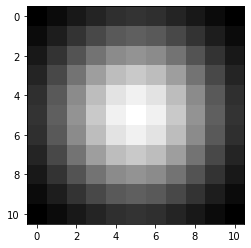

In [14]:
print(w)
plt.imshow(w, cmap='gray')

In [15]:
%%time

out_img = []
for c in range(3):
    out_img.append(scipy.signal.correlate2d(img[:,:,c], w, mode='valid'))
out_img = np.stack(out_img, axis=2)

CPU times: total: 406 ms
Wall time: 393 ms


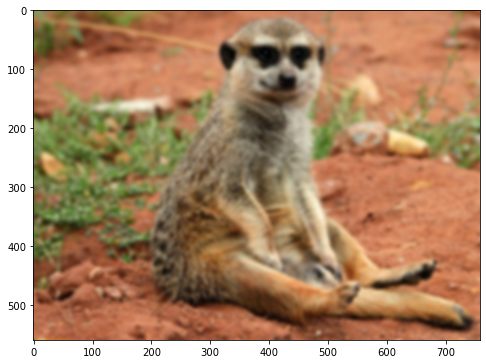

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(out_img)

## Детектор границ

In [17]:
win_size = (3, 3)
w1 = np.zeros(win_size, dtype=np.int16)
w1[:,0] = -1
w1[:,2] = 1
print(w1)

[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]


In [18]:
w2 = np.copy(w1).T
print(w2)

[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


In [19]:
def apply_filter(img, w):
    out_img = np.zeros(
        (img.shape[0] - w.shape[0] + 1,
         img.shape[1] - w.shape[1] + 1), 
        dtype=np.float32)

    for i in range(out_img.shape[0]):
        for j in range(out_img.shape[1]):
            x = img[i:i+w.shape[0], j:j+w.shape[1]]
            out_img[i,j] = np.sum(w * x)
    return out_img

In [20]:
%%time
out_img1 = apply_filter(img_bw, w1)

CPU times: total: 2.52 s
Wall time: 2.52 s


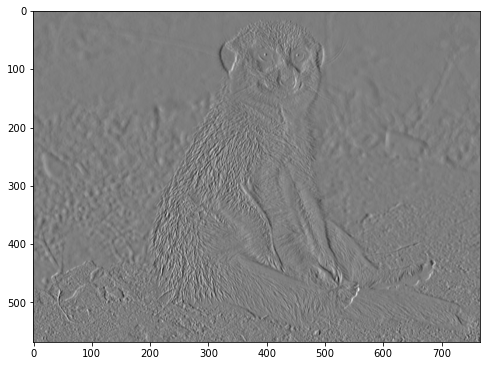

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(out_img1, cmap='gray')

In [22]:
%%time
out_img2 = apply_filter(img_bw, w2)

CPU times: total: 3.14 s
Wall time: 3.23 s


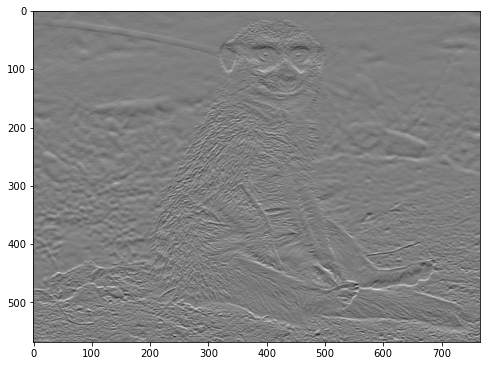

In [23]:
plt.figure(figsize=(8, 8))
plt.imshow(out_img2, cmap='gray')

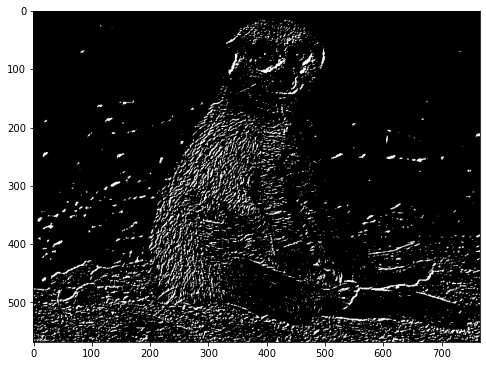

In [24]:
threshold = 0.35 # порог бинаризации
img_bin = (out_img1+out_img2 > threshold).astype(np.uint8)
plt.figure(figsize=(8, 8))
plt.imshow(img_bin*255, cmap='gray')